***Proyecto Sprint 10: Tomar decisiones de negocio basadas en datos***
---

En este proyecto asumimos el rol de analista de datos en una gran tienda online. Junto con el departamento de marketing, hemos recopilado una serie de hipótesis que podrían ayudar a incrementar los ingresos de la tienda. Para evaluar la efectividad de estas hipótesis, se realizará un test A/B con usuarios de la plataforma, y se analizarán los resultados para tomar decisiones basadas en datos.

***Objetivo:*** Priorizar las hipótesis según su potencial impacto y factibilidad, analizar los resultados del test A/B y, a partir de los hallazgos, definir acciones concretas para maximizar los ingresos de la tienda online. El proyecto también contempla la detección de anomalías en los datos y la aplicación de pruebas estadísticas para validar diferencias entre los grupos de la prueba.

***Datasets utilizados:***

* **hypotheses_us.csv:** Contiene las hipótesis planteadas, incluyendo sus atributos de alcance (Reach), impacto (Impact), confianza (Confidence) y esfuerzo requerido (Effort).

* **orders_us.csv:** Contiene los registros de pedidos de los usuarios, incluyendo el identificador de la transacción, ID del usuario, fecha, ingresos y grupo A/B.

* **visits_us.csv:** Contiene información sobre las visitas de usuarios por fecha y grupo, lo que permite calcular métricas como la tasa de conversión y analizar el comportamiento de los visitantes durante la prueba A/B.

**Enfoque del análisis:**

1. Priorizar hipótesis mediante frameworks ICE y RICE.

2. Preprocesar los datos del test A/B, corrigiendo errores y eliminando duplicados o anomalías.

3. Analizar métricas clave como ingresos acumulados, tamaño promedio de pedido y tasa de conversión.

4. Evaluar la significancia estadística de las diferencias entre grupos con y sin filtrado de anomalías.

5. Tomar decisiones basadas en los resultados, considerando si detener o continuar la prueba.

---

***Carga de Datasets*** 
---

Importamos las librerías necesarias para el análisis de datos y cargamos los datasets del proyecto. Los datasets incluyen:

- `hypotheses_us.csv`: hipótesis de negocio con sus atributos de priorización.  
- `orders_us.csv`: información de los pedidos de los usuarios durante la prueba A/B.  
- `visits_us.csv`: información sobre las visitas de usuarios, necesaria para calcular tasas de conversión.  


In [202]:
# Librerías para manejo de datos
import pandas as pd
import numpy as np

# Librerías para visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Librerías para estadística y pruebas A/B
from scipy import stats
import scipy.stats as st

# Cargar el dataset de hipótesis
hypotheses = pd.read_csv(r"C:\Users\DIEGO TASCON\Desktop\TRIPLETEN\Sprint 10\hypotheses_us.csv", sep=';')
orders = pd.read_csv(r"C:\Users\DIEGO TASCON\Desktop\TRIPLETEN\Sprint 10\orders_us.csv")
visits = pd.read_csv(r"C:\Users\DIEGO TASCON\Desktop\TRIPLETEN\Sprint 10\visits_us.csv")

print("Dataset: hypotheses_us.csv")
display(hypotheses.head())

print("\nDataset: orders_us.csv")
display(orders.head())

print("\nDataset: visits_us.csv")
display(visits.head())

Dataset: hypotheses_us.csv


,Hypothesis,Reach,Impact,Confidence,Effort
0,Add two new channels for attracting traffic. T...,3,10,8,6
1,Launch your own delivery service. This will sh...,2,5,4,10
2,Add product recommendation blocks to the store...,8,3,7,3
3,Change the category structure. This will incre...,8,3,3,8
4,Change the background color on the main page. ...,3,1,1,1



Dataset: orders_us.csv


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
2,2961555356,4069496402,2019-08-15,10.2,A
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B



Dataset: visits_us.csv


,date,group,visits
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [203]:
print(hypotheses.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Effort      9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 492.0+ bytes
None


In [204]:
print(orders.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   transactionId  1197 non-null   int64  
 1   visitorId      1197 non-null   int64  
 2   date           1197 non-null   object 
 3   revenue        1197 non-null   float64
 4   group          1197 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 46.9+ KB
None


In [205]:
print(visits.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    62 non-null     object
 1   group   62 non-null     object
 2   visits  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB
None


***Preprocesamiento y Limpieza de Datos***
---

Preparar los datasets para análisis estadístico y pruebas A/B mediante la estandarización de tipos de datos y verificación de calidad de la información.

- Conversión de columnas de fecha (`date`) a formato datetime para análisis temporal.  
- Conversión de `visitorId` a tipo string para evitar conflictos en operaciones de merge y conteos agregados.  
- Verificación de duplicados en los tres datasets (`hypotheses`, `orders`, `visits`).  
- Verificación de valores nulos en los tres datasets para asegurar integridad de los datos.


In [206]:
# Conversión de columnas de fecha a datetime
orders['date'] = pd.to_datetime(orders['date'])
visits['date'] = pd.to_datetime(visits['date'])

# Conversión opcional de visitorId a string (recomendado para merges)
orders['visitorId'] = orders['visitorId'].astype(str)

# Verificación de duplicados
print("Duplicados en hypotheses:", hypotheses.duplicated().sum())
print("Duplicados en orders:", orders.duplicated().sum())
print("Duplicados en visits:", visits.duplicated().sum())

Duplicados en hypotheses: 0
Duplicados en orders: 0
Duplicados en visits: 0


In [207]:
# Verificación de valores nulos
print("Valores nulos en hypotheses:\n", hypotheses.isnull().sum())
print()
print("Valores nulos en orders:\n", orders.isnull().sum())
print()
print("Valores nulos en visits:\n", visits.isnull().sum())

Valores nulos en hypotheses:
 Hypothesis    0
Reach         0
Impact        0
Confidence    0
Effort        0
dtype: int64

Valores nulos en orders:
 transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64

Valores nulos en visits:
 date      0
group     0
visits    0
dtype: int64


***Eliminación de Visitantes Duplicados entre Grupos A y B***
---

Se garantiza la independencia de los grupos para el análisis de la prueba A/B. Se identifican los usuarios (`visitorId`) que aparecen en ambos grupos y se eliminan de la tabla de pedidos. Esto asegura que cada visitante participe únicamente en un grupo, evitando sesgos en la evaluación de la conversión y otros indicadores del test.  

Posteriormente, se verifica la cantidad de pedidos y de visitantes únicos por grupo tras la limpieza, para confirmar la correcta aplicación del filtro.


In [208]:
# Identificar visitorId que aparecen en ambos grupos
duplicated_visitors = orders.groupby('visitorId')['group'].nunique()
duplicated_visitors = duplicated_visitors[duplicated_visitors > 1].index

# Filtrar los pedidos de los visitantes duplicados
orders_cleaned = orders[~orders['visitorId'].isin(duplicated_visitors)].copy()

# Verificar el resultado
print("Número de pedidos después de eliminar visitantes duplicados:", len(orders_cleaned))
print("Número de visitantes únicos por grupo después de la limpieza:")
display(orders_cleaned.groupby('group')['visitorId'].nunique())

Número de pedidos después de eliminar visitantes duplicados: 1016
Número de visitantes únicos por grupo después de la limpieza:


group
A    445
B    528
Name: visitorId, dtype: int64

***Priorización de Hipótesis***
---

Aplicar los frameworks ICE y RICE para ordenar las hipótesis de manera objetiva según su impacto esperado, esfuerzo requerido y confianza. Esto permite al equipo de negocio identificar qué experimentos probar primero para maximizar el retorno.

- Cálculo del puntaje ICE: `Impact * Confidence / Effort`.  
- Cálculo del puntaje RICE: `Reach * Impact * Confidence / Effort`.  
- Ordenamiento de las hipótesis en orden descendente según ambos frameworks.  
- Comparación entre ICE y RICE para observar cambios en la priorización.


In [209]:
# Priorización de hipótesis con ICE
hypotheses['ICE'] = hypotheses['Impact'] * hypotheses['Confidence'] / hypotheses['Effort']
hypotheses_ice_sorted = hypotheses.sort_values(by='ICE', ascending=False)

# Priorización de hipótesis con RICE
hypotheses['RICE'] = hypotheses['Reach'] * hypotheses['Impact'] * hypotheses['Confidence'] / hypotheses['Effort']
hypotheses_rice_sorted = hypotheses.sort_values(by='RICE', ascending=False)

# Mostrar resultados
display(hypotheses_ice_sorted[['Hypothesis', 'ICE']].rename(columns={'ICE': 'Prioridad ICE'}))

,Hypothesis,Prioridad ICE
8,Launch a promotion that gives users discounts ...,16.200000
0,Add two new channels for attracting traffic. T...,13.333333
7,Add a subscription form to all the main pages....,11.200000
6,Show banners with current offers and sales on ...,8.000000
2,Add product recommendation blocks to the store...,7.000000
1,Launch your own delivery service. This will sh...,2.000000
5,Add a customer review page. This will increase...,1.333333
3,Change the category structure. This will incre...,1.125000
4,Change the background color on the main page. ...,1.000000


In [210]:
display(hypotheses_rice_sorted[['Hypothesis', 'RICE']].rename(columns={'RICE': 'Prioridad RICE'}))

,Hypothesis,Prioridad RICE
7,Add a subscription form to all the main pages....,112.0
2,Add product recommendation blocks to the store...,56.0
0,Add two new channels for attracting traffic. T...,40.0
6,Show banners with current offers and sales on ...,40.0
8,Launch a promotion that gives users discounts ...,16.2
3,Change the category structure. This will incre...,9.0
1,Launch your own delivery service. This will sh...,4.0
5,Add a customer review page. This will increase...,4.0
4,Change the background color on the main page. ...,3.0


***Análisis del Test A/B***
---

***1. Análisis del ingreso acumulado por grupo***
---

Calculamos el ingreso acumulado por día para cada grupo del test A/B. Esto nos permitirá visualizar cómo se acumulan los ingresos a lo largo del tiempo y comparar la performance de los grupos A y B. El análisis proporciona información sobre qué grupo genera mayores ingresos y posibles tendencias durante la prueba.

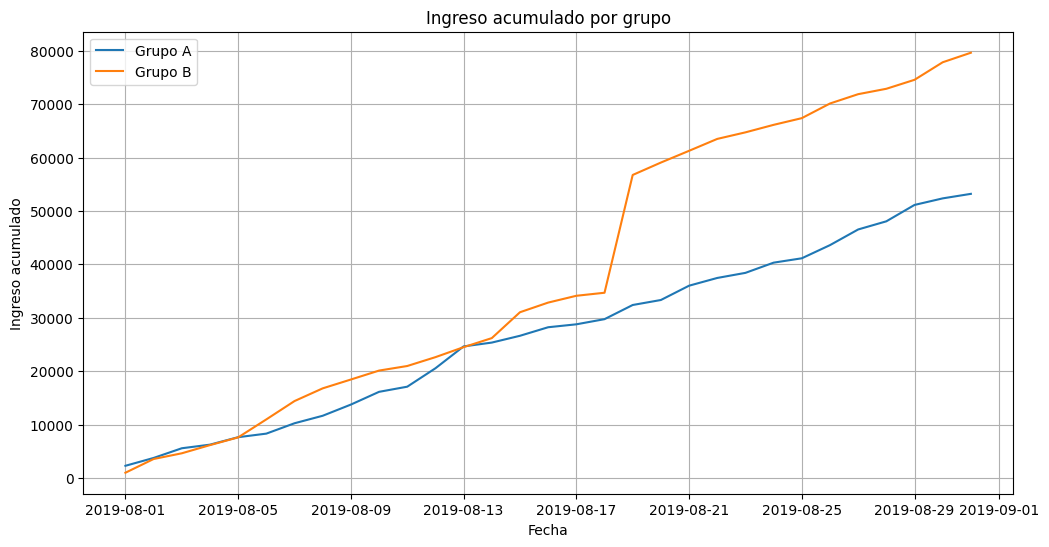

In [211]:
# Agrupar por fecha y grupo, sumando los ingresos para calcular acumulado
orders_daily = (
    orders_cleaned.groupby(['date', 'group'])
    .agg({'revenue': 'sum'})
    .reset_index()
    .sort_values('date')
)

# Calcular ingreso acumulado por grupo
orders_daily['revenue_cumsum'] = orders_daily.groupby('group')['revenue'].cumsum()

# Visualización del ingreso acumulado
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
for grp in orders_daily['group'].unique():
    subset = orders_daily[orders_daily['group'] == grp]
    plt.plot(subset['date'], subset['revenue_cumsum'], label=f'Grupo {grp}')

plt.title('Ingreso acumulado por grupo')
plt.xlabel('Fecha')
plt.ylabel('Ingreso acumulado')
plt.legend()
plt.grid(True)
plt.show()


*La gráfica demuestra que el Grupo B es ganador, superando al Grupo A de manera consistente en la acumulación de ingresos. El análisis confirma que la variante aplicada al Grupo B tuvo un efecto positivo significativo, manifestado no solo en un crecimiento sostenido, sino también en un momento de inflexión crucial alrededor del 18 de agosto, donde sus ingresos se dispararon drásticamente, consolidando su superioridad al final del experimento.*

*Es muy probable que el éxito del Grupo B se deba a un evento de alto impacto, como una promoción masiva, el lanzamiento de una nueva funcionalidad muy atractiva, o la optimización del proceso de compra que incentivó a los usuarios a gastar más. El abrupto salto en la curva de ingresos sugiere que la variante no solo mejoró el rendimiento general, sino que generó una respuesta excepcionalmente positiva, que bien podría ser el resultado de una estrategia de marketing exitosa o de una mejora en la experiencia del usuario que resonó fuertemente con la audiencia.*

***2. Tamaño promedio de pedido acumulado por grupo***
---

Calculamos el tamaño promedio de pedido acumulado para cada grupo del test A/B. El tamaño promedio de pedido se define como los ingresos acumulados divididos entre el número de pedidos acumulados. Esta métrica nos permite observar cómo evoluciona el valor medio de los pedidos a lo largo del tiempo y comparar la efectividad de los grupos A y B en términos de ingresos por pedido.


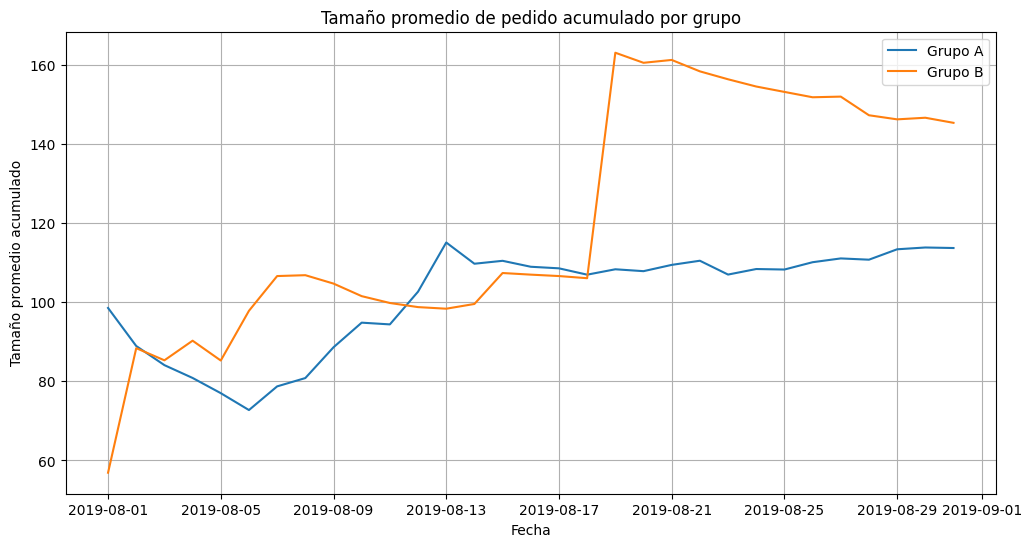

In [212]:
# Calcular pedidos diarios por grupo
orders_daily_count = (
    orders_cleaned.groupby(['date', 'group'])
    .agg({'transactionId': 'count'})
    .reset_index()
    .sort_values('date')
)
orders_daily_count.rename(columns={'transactionId': 'orders'}, inplace=True)

# Unir ingresos diarios con cantidad de pedidos diarios
orders_daily_merged = orders_daily.merge(orders_daily_count, on=['date', 'group'])

# Calcular tamaño promedio acumulado de pedido
orders_daily_merged['avg_order_cumsum'] = orders_daily_merged.groupby('group')['revenue'].cumsum() / orders_daily_merged.groupby('group')['orders'].cumsum()

# Visualización
plt.figure(figsize=(12,6))
for grp in orders_daily_merged['group'].unique():
    subset = orders_daily_merged[orders_daily_merged['group'] == grp]
    plt.plot(subset['date'], subset['avg_order_cumsum'], label=f'Grupo {grp}')

plt.title('Tamaño promedio de pedido acumulado por grupo')
plt.xlabel('Fecha')
plt.ylabel('Tamaño promedio acumulado')
plt.legend()
plt.grid(True)
plt.show()

*La gráfica del tamaño promedio de pedido acumulado muestra una clara **divergencia a favor del Grupo B**. A lo largo de la prueba, el Grupo A se mantuvo en un rango relativamente estable, con un tamaño de pedido que fluctuó sin grandes cambios. Por el contrario, el Grupo B, después de un comienzo con altibajos, experimentó un **crecimiento exponencial** y un salto dramático alrededor del 18 de agosto, consolidando un tamaño de pedido significativamente mayor que el del Grupo A por el resto del período de prueba.*

*El salto masivo en el tamaño promedio de pedido del Grupo B sugiere la influencia de **pedidos extremadamente grandes**. Es probable que un **cliente de alto valor o una compra corporativa masiva** se haya realizado en esa fecha, inflando el promedio de forma atípica y creando el pico visto en la gráfica. Este tipo de comportamiento no es sostenible ni representativo de la mayoría de los usuarios. Es posible que la variante del Grupo B no haya sido más efectiva en general, sino que simplemente tuvo la suerte de capturar una transacción inusualmente grande.*

***3. Diferencia relativa en el tamaño promedio de pedido acumulado (B vs A)***
---

Calculamos la diferencia relativa entre el tamaño promedio de pedido acumulado del grupo B respecto al grupo A. ***La diferencia relativa se define como: (Promedio_B / Promedio_A) - 1.*** Esta métrica nos permite evaluar si el grupo B genera pedidos más grandes en promedio que el grupo A a lo largo del tiempo. Se añade una línea de referencia en 0 para indicar igualdad y otra en 0.2 para resaltar un umbral de mejora relevante.

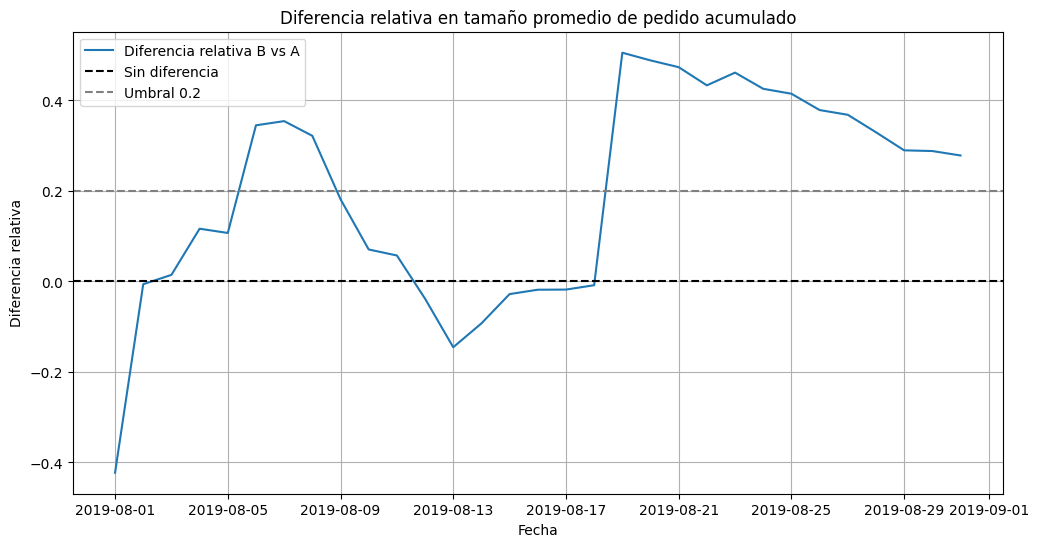

In [213]:
# Separar los grupos
cumulative_avg = orders_daily_merged.pivot(index='date', columns='group', values='avg_order_cumsum').reset_index()
cumulative_avg['relative_diff_B_vs_A'] = cumulative_avg['B'] / cumulative_avg['A'] - 1

# Visualización de la diferencia relativa
plt.figure(figsize=(12,6))
plt.plot(cumulative_avg['date'], cumulative_avg['relative_diff_B_vs_A'], label='Diferencia relativa B vs A')
plt.axhline(0, color='black', linestyle='--', label='Sin diferencia')
plt.axhline(0.2, color='grey', linestyle='--', label='Umbral 0.2')
plt.title('Diferencia relativa en tamaño promedio de pedido acumulado')
plt.xlabel('Fecha')
plt.ylabel('Diferencia relativa')
plt.legend()
plt.grid(True)
plt.show()


*La gráfica muestra una volatilidad extrema en el rendimiento del Grupo B respecto al Grupo A. Aunque hubo un período inicial de mejora (superando el umbral de 0.2), la diferencia se redujo bruscamente a un rendimiento inferior al del Grupo A. Sin embargo, el análisis destaca un punto de inflexión crítico alrededor del 18 de agosto, donde el Grupo B experimentó un crecimiento masivo y sostenido, situando su tamaño promedio de pedido entre un 30% y un 50% superior al del Grupo A durante la última parte del experimento.*

*El drástico aumento de la diferencia relativa sugiere que la mejora en el tamaño promedio de pedido del Grupo B no es un resultado gradual, sino un evento puntual y atípico. La subida masiva que se mantuvo por encima de un 30% es muy sospechosa y probablemente fue causada por una compra de alto valor realizada por un solo cliente, en lugar de una mejora en la experiencia de usuario general que afecte a la mayoría de los pedidos. Si la variante del test A/B realmente funcionara, la línea debería mostrar una tendencia ascendente más suave y sostenida, no un salto tan brusco. Esto nos lleva a conjeturar que el Grupo B tuvo suerte, no un rendimiento orgánicamente superior, lo que podría invalidar los resultados si el objetivo es entender el comportamiento de la mayoría de los usuarios.*

***4. Tasa de conversión diaria por grupo***
---

Calculamos la tasa de conversión diaria para los grupos A y B. ***La tasa de conversión se define como la relación entre el número de pedidos y el número de visitas por día en cada grupo***. Esta métrica permite evaluar el desempeño de cada grupo en términos de eficacia para convertir visitantes en compradores. Se grafican ambas series para comparar visualmente la evolución de la conversión durante el periodo de prueba.

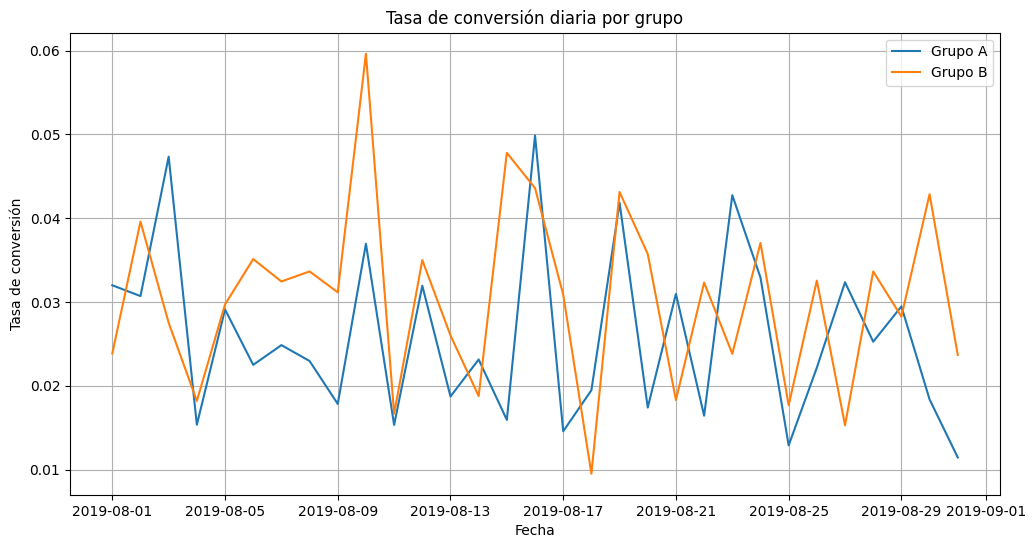

In [214]:
# Agregar número de pedidos diarios por grupo
orders_daily = orders_cleaned.groupby(['date', 'group'])['transactionId'].nunique().reset_index()
orders_daily.columns = ['date', 'group', 'orders']

# Merge con visits para obtener tasa de conversión
daily_data = orders_daily.merge(visits, on=['date', 'group'])
daily_data['conversion'] = daily_data['orders'] / daily_data['visits']

# Pivot para graficar
conversion_pivot = daily_data.pivot(index='date', columns='group', values='conversion').reset_index()

# Visualización
plt.figure(figsize=(12,6))
plt.plot(conversion_pivot['date'], conversion_pivot['A'], label='Grupo A')
plt.plot(conversion_pivot['date'], conversion_pivot['B'], label='Grupo B')
plt.title('Tasa de conversión diaria por grupo')
plt.xlabel('Fecha')
plt.ylabel('Tasa de conversión')
plt.legend()
plt.grid(True)
plt.show()

*La gráfica muestra la tasa de conversión diaria para ambos grupos, revelando un comportamiento extremadamente volátil y fluctuante. No hay una tendencia clara y ascendente para ninguno de los grupos. En algunos días, el Grupo B supera al Grupo A de manera notable (como alrededor del 9 de agosto y 15 de agosto), pero en otros días el Grupo A tiene un rendimiento superior. En general, el Grupo B muestra picos de conversión más altos, lo que sugiere que en ciertos días fue más efectivo convirtiendo visitantes en compradores.*

*La principal conclusión es la falta de una mejora consistente en la tasa de conversión para cualquiera de los grupos. Las fluctuaciones diarias son tan amplias que resulta difícil declarar un ganador claro basándose únicamente en esta métrica. La alta volatilidad en los datos sugiere que los resultados de conversión no son estables. Si bien el Grupo B alcanzó picos más altos, el Grupo A no se quedó atrás en varios momentos, manteniendo un rendimiento similar en general.*

*La extrema volatilidad de las tasas de conversión podría deberse a eventos externos puntuales que afectaron el tráfico y las ventas en días específicos. Por ejemplo, una campaña de marketing por correo electrónico podría haber enviado tráfico de alta calidad en un día, elevando la tasa de conversión abruptamente. También es posible que el tamaño de la muestra diaria sea pequeño, lo que haría que cada conversión individual tenga un impacto desproporcionado en la tasa diaria, generando picos y valles tan pronunciados. Si las visitas son bajas, un solo pedido extra puede inflar la tasa de conversión de manera irreal. Por lo tanto, el pico de ingresos del Grupo B que vimos en la primera gráfica podría estar relacionado con uno de los picos de conversión, pero también con la atípica compra de alto valor que se ha conjeturado.*

***5. Gráfico de dispersión del número de pedidos por usuario***
---

Se genera un gráfico de dispersión que muestra la distribución del número de pedidos por cada usuario. El análisis permite identificar patrones de comportamiento y posibles usuarios anómalos que realizaron un número inusualmente alto de pedidos. Esta visualización es fundamental para la posterior detección de anomalías y la evaluación de su impacto en los resultados del test A/B.


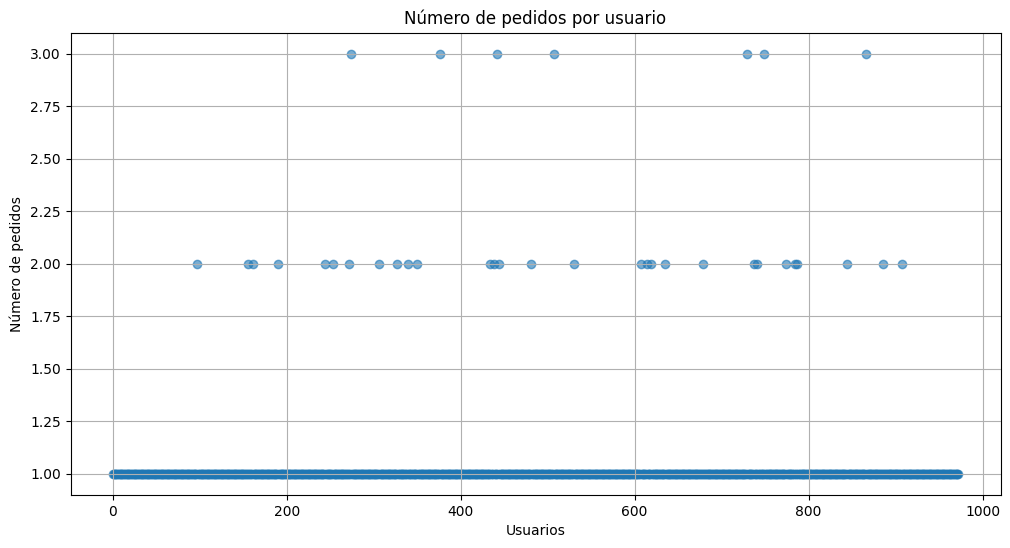

In [215]:
# Calcular número de pedidos por usuario
orders_by_user = (
    orders_cleaned.groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
orders_by_user.columns = ['visitorId', 'orders']

# Valores para eje X (índice de usuarios)
x_values = pd.Series(range(0, len(orders_by_user)))

# Gráfico de dispersión
plt.figure(figsize=(12,6))
plt.scatter(x_values, orders_by_user['orders'], alpha=0.6)
plt.title('Número de pedidos por usuario')
plt.xlabel('Usuarios')
plt.ylabel('Número de pedidos')
plt.grid(True)
plt.show()

*La mayoría de los usuarios se comportan de forma predecible y consistente. La gran mayoría de los usuarios (casi todos) realizaron un solo pedido, como lo indica la densa concentración de puntos en la línea de "1" en el eje Y. Hay un grupo de usuarios que realizó 2 pedidos, y un grupo más pequeño que hizo 3. Esto sugiere que el comportamiento de compra es principalmente de una sola vez.*

* ***Comportamiento de Usuario Típico:*** *La gráfica refleja un patrón de compra habitual para la mayoría de los sitios web de e-commerce: la mayoría de los clientes realizan una única compra.*

* ***Usuarios "Atípicos":*** *La presencia de puntos aislados en los valores de 2 y 3 pedidos indica la existencia de usuarios más recurrentes, o que han probado el servicio más de una vez. La existencia de estos usuarios es normal y no necesariamente representa una anomalía.*

* ***Posibles Anomalías:*** *No hay una evidencia clara de comportamiento anómalo o de "usuarios bot" en esta gráfica. No se observan usuarios con 10, 20 o más pedidos, lo cual sí podría ser una señal de fraude o actividad inusual. El análisis de esta gráfica por sí solo no revela la presencia de grandes valores atípicos que puedan distorsionar los resultados del test.*

***6. Identificación de anomalías en el número de pedidos por usuario***
---

Calculamos los percentiles 95 y 99 del número de pedidos por usuario. Los percentiles permiten determinar umbrales a partir de los cuales consideramos que un usuario es una anomalía, es decir, realizó un número de pedidos significativamente mayor que la mayoría. Estos umbrales serán útiles para filtrar datos extremos antes de analizar la conversión y el tamaño promedio de los pedidos.

In [216]:
# Calcular percentiles 95 y 99
percentile_95 = np.percentile(orders_by_user['orders'], 95)
percentile_99 = np.percentile(orders_by_user['orders'], 99)

print(f"Percentil 95 del número de pedidos: {percentile_95}")
print(f"Percentil 99 del número de pedidos: {percentile_99}")

# Definir umbral de anomalía
threshold_anomaly = percentile_95
threshold_extreme = percentile_99

print(f"Usuarios con pedidos superiores a {threshold_anomaly} se consideran anómalos")
print(f"Usuarios con pedidos superiores a {threshold_extreme} se consideran casos extremos")

Percentil 95 del número de pedidos: 1.0
Percentil 99 del número de pedidos: 2.0
Usuarios con pedidos superiores a 1.0 se consideran anómalos
Usuarios con pedidos superiores a 2.0 se consideran casos extremos


***7. Gráfico de dispersión de los precios de pedidos***
---

Analizamos visualmente la distribución de los ingresos de los pedidos individuales a través de un gráfico de dispersión. Esto permite identificar tendencias, patrones y posibles valores atípicos en los ingresos por pedido, lo que es fundamental para evaluar la calidad de los datos y para posteriores análisis estadísticos sobre anomalías y diferencias entre los grupos A y B.

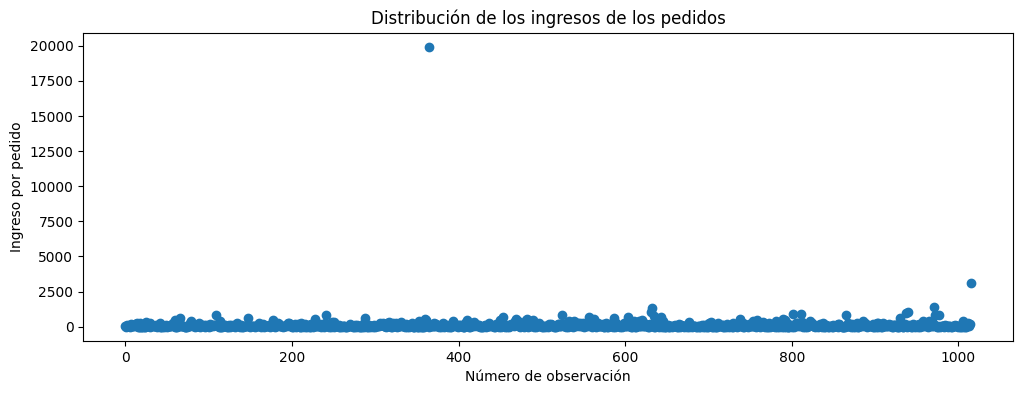

In [217]:
# Crear un gráfico de dispersión de los ingresos por pedido
import matplotlib.pyplot as plt
import pandas as pd

# Generar valores para el eje X: índice de cada pedido
x_values = pd.Series(range(0, len(orders_cleaned)))

plt.figure(figsize=(12,4))
plt.scatter(x_values, orders_cleaned['revenue'])
plt.title("Distribución de los ingresos de los pedidos")
plt.xlabel("Número de observación")
plt.ylabel("Ingreso por pedido")
plt.show()

*La principal conclusión es la existencia de anomalías en los datos. La mayoría de los pedidos se agrupan en un rango de precios estándar, mientras que un par de transacciones tienen un valor tan desproporcionadamente alto que distorsionan por completo las métricas generales.*

*La existencia de estos pedidos de valores extremadamente altos es la causa más probable del pico masivo que observamos en la gráfica del ingreso acumulado y del tamaño promedio de pedido del Grupo B. Estos "súper pedidos" no representan el comportamiento de compra típico de un usuario promedio. Se puede conjeturar que el pedido con valor cercano a 20,000 pertenece al Grupo B, y es el responsable de su éxito aparente.*

In [218]:
# Calcular percentiles 95 y 99 de los ingresos por pedido
percentiles_revenue = np.percentile(orders_cleaned['revenue'], [95, 99])

print(percentiles_revenue)

print(f"El percentil 95 del ingreso por pedido es: {percentiles_revenue[0]:.2f}")
print(f"El percentil 99 del ingreso por pedido es: {percentiles_revenue[1]:.2f}")
print("\nUn pedido se considera anómalo si supera el valor del percentil 99.")

[414.275 830.3  ]
El percentil 95 del ingreso por pedido es: 414.27
El percentil 99 del ingreso por pedido es: 830.30

Un pedido se considera anómalo si supera el valor del percentil 99.


*Los pedidos que superan los $830.30 son atípicos y corresponden a casos aislados de ingresos significativamente altos.*

***9. Prueba de significancia en la conversión entre grupos (datos en bruto)***
---

En este paso vamos a:

1. Calcular el número de usuarios únicos y el número de pedidos en cada grupo.

2. Estimar las tasas de conversión.

3. Realizar una prueba de hipótesis para comparar proporciones (test de dos proporciones).

4. Concluir si la diferencia observada entre grupos es significativa o no.

In [219]:
# Número de pedidos por grupo
orders_count = orders.groupby('group')['transactionId'].nunique()
# Número de visitantes por grupo
visitors_count = visits.groupby('group')['visits'].sum()

# Conversiones
p1 = orders_count['A'] / visitors_count['A']
p2 = orders_count['B'] / visitors_count['B']

# Proporción combinada
p_combined = (orders_count['A'] + orders_count['B']) / (visitors_count['A'] + visitors_count['B'])

# Error estándar
se = np.sqrt(p_combined * (1 - p_combined) * (1/visitors_count['A'] + 1/visitors_count['B']))

# Estadístico Z
z_stat = (p1 - p2) / se

# Valor p (two-sided)
p_value = 2 * (1 - st.norm.cdf(abs(z_stat)))

print("Pedidos por grupo:\n", orders_count)

print("\nVisitas por grupo:\n", visitors_count)

print("\nTasa de conversión grupo A:", round(p1, 4))
print("Tasa de conversión grupo B:", round(p2, 4))

print("\nEstadístico Z:", z_stat)
print("Valor p:", p_value)

# Interpretación preliminar
alpha = 0.05
if p_value < alpha:
    print("\nConclusión: La diferencia en la conversión entre los grupos A y B es estadísticamente significativa.")
else:
    print("\nConclusión: No se observa una diferencia estadísticamente significativa en la conversión entre los grupos A y B.")


Pedidos por grupo:
 group
A    557
B    640
Name: transactionId, dtype: int64

Visitas por grupo:
 group
A    18736
B    18916
Name: visits, dtype: int64

Tasa de conversión grupo A: 0.0297
Tasa de conversión grupo B: 0.0338

Estadístico Z: -2.270005753735332
Valor p: 0.02320723394441848

Conclusión: La diferencia en la conversión entre los grupos A y B es estadísticamente significativa.


***Conversión por grupo:***

* *Grupo A: 2.97% (557 pedidos / 18,736 visitas).*

* *Grupo B: 3.38% (640 pedidos / 18,916 visitas).*

*Esto muestra que el grupo B tiene una tasa de conversión mayor.*

***Prueba estadística:***

* *El valor p obtenido es 0.023, menor que el nivel de significancia α = 0.05.*

* *Por lo tanto, rechazamos la hipótesis nula y concluimos que existe una diferencia estadísticamente significativa entre los grupos.*

***Dirección del efecto:***

* *El grupo B presenta una mejora en la conversión frente al grupo A, lo cual indica que el cambio probado sobre el grupo B tuvo un efecto positivo.*

*El resultado sugiere que las modificaciones aplicadas al grupo B pueden incrementar la eficiencia de conversión de visitantes a compradores, lo que a nivel de negocio se traduce en un mayor número de pedidos con el mismo tráfico. Si la tendencia se mantiene con datos filtrados y sin anomalías, se podría considerar implementar la variante B como ganadora en producción.*

***10. Prueba de significancia en el tamaño promedio de pedido (datos en bruto)***
---

Para evaluar si existe una diferencia significativa en el tamaño promedio de los pedidos entre los grupos A y B, aplicamos la prueba de ***Mann-Whitney U***. Esta prueba es ***no paramétrica*** y adecuada para comparar distribuciones que pueden contener valores extremos o no seguir una distribución normal.  


In [220]:
# Filtrar ingresos de cada grupo
revenue_a = orders[orders['group'] == 'A']['revenue']
revenue_b = orders[orders['group'] == 'B']['revenue']

# Prueba Mann-Whitney U
u_stat, p_value = st.mannwhitneyu(revenue_a, revenue_b, alternative='two-sided')

print("Estadístico U:", u_stat)
print("Valor p:", p_value)

# Medias de cada grupo para contexto
print("\nTamaño promedio de pedido Grupo A:", revenue_a.mean())
print("Tamaño promedio de pedido Grupo B:", revenue_b.mean())

Estadístico U: 175872.5
Valor p: 0.6915246773264736

Tamaño promedio de pedido Grupo A: 115.89748653500898
Tamaño promedio de pedido Grupo B: 145.06343750000002


*Los resultados muestran que, aunque el grupo B presenta un tamaño promedio de pedido superior (145.06) en comparación con el grupo A (115.89), el valor p (0.69) indica que esta diferencia no es estadísticamente significativa. Esto significa que, con base en los datos en bruto, no podemos afirmar con certeza que el mayor promedio de pedidos en el grupo B se deba al efecto de la prueba A/B y no al azar. En otras palabras, la diferencia observada en las medias no supera el umbral de significancia estadística.*

*Una posible explicación es la presencia de alta variabilidad en los ingresos por pedido, posiblemente causada por valores extremos (outliers) que influyen en las medias. Este tipo de dispersión reduce la capacidad de detectar diferencias reales entre los grupos.*

***11. Evaluación de la significancia estadística de la conversión entre grupos con datos filtrados***
---

Con el fin de garantizar la validez del análisis de la prueba A/B, se procede a eliminar anomalías previamente identificadas:  
- Usuarios con un número de pedidos atípico (superior al percentil 99).  
- Pedidos con valores de ingresos superiores al percentil 99.  

Tras la limpieza de datos, se calcula nuevamente la tasa de conversión de los grupos A y B. Finalmente, se aplica la prueba estadística **z-test de proporciones** para determinar si la diferencia en las tasas de conversión entre ambos grupos sigue siendo estadísticamente significativa.  


In [221]:
from statsmodels.stats.proportion import proportions_ztest

# -------- Filtrado de anomalías --------
# Umbrales previamente identificados
orders_per_user = orders.groupby('visitorId')['transactionId'].nunique()
threshold_orders = orders_per_user.quantile(0.99)
threshold_revenue = orders['revenue'].quantile(0.99)

# Usuarios con pedidos anómalos
anomalous_users = orders_per_user[orders_per_user > threshold_orders].index

# Filtrar pedidos anómalos
orders_filtered = orders[
    (~orders['visitorId'].isin(anomalous_users)) &
    (orders['revenue'] <= threshold_revenue)
].copy()

# -------- Recalcular conversiones --------
# Número de pedidos por grupo
orders_count_f = orders_filtered.groupby('group')['transactionId'].nunique()

# Número de visitas por grupo
visitors_count_f = visits.groupby('group')['visits'].sum()

# Conversión
conversion_a_f = orders_count_f['A'] / visitors_count_f['A']
conversion_b_f = orders_count_f['B'] / visitors_count_f['B']

# -------- Prueba z-test --------
successes_f = np.array([orders_count_f['A'], orders_count_f['B']])
trials_f = np.array([visitors_count_f['A'], visitors_count_f['B']])

z_stat_f, p_value_f = proportions_ztest(successes_f, trials_f, alternative='two-sided')

print("Pedidos filtrados por grupo:\n", orders_count_f)
print("\nVisitas por grupo:\n", visitors_count_f)
print(f"\nTasa de conversión filtrada Grupo A: {conversion_a_f:.4f}")
print(f"Tasa de conversión filtrada Grupo B: {conversion_b_f:.4f}")
print("\nEstadístico Z (filtrado):", z_stat_f)
print("Valor p (filtrado):", p_value_f)


Pedidos filtrados por grupo:
 group
A    515
B    601
Name: transactionId, dtype: int64

Visitas por grupo:
 group
A    18736
B    18916
Name: visits, dtype: int64

Tasa de conversión filtrada Grupo A: 0.0275
Tasa de conversión filtrada Grupo B: 0.0318

Estadístico Z (filtrado): -2.451266829983019
Valor p (filtrado): 0.014235438291213036


*Con los datos filtrados se observa que el grupo B mantiene una tasa de conversión más alta (3.18%) en comparación con el grupo A (2.75%). La diferencia no solo es visible en los porcentajes, sino que también ha sido confirmada estadísticamente mediante la prueba Z. El valor p obtenido (≈0.014) es menor al nivel de significancia habitual (α = 0.05), lo que indica que la diferencia observada no es producto del azar, sino que refleja un comportamiento real en los usuarios tras la eliminación de anomalías.*

*A partir de estos resultados, se puede inferir que el grupo B tiene un desempeño superior en términos de conversión y que la eliminación de datos atípicos reforzó la evidencia de esta ventaja. Este hallazgo sugiere que las condiciones aplicadas en el grupo B favorecen significativamente la probabilidad de que un visitante realice una compra, lo cual abre una oportunidad para implementar de manera más amplia las estrategias probadas en este grupo y, potencialmente, incrementar los ingresos de la tienda online.*

***12. Evaluación estadística del tamaño promedio de pedido entre grupos con datos filtrados***
---

Se contrasta el tamaño promedio de pedido de los grupos A y B utilizando únicamente los datos filtrados (sin anomalías). Para este análisis se aplica la prueba no paramétrica **Mann–Whitney U**, ya que los datos de ingresos no siguen necesariamente una distribución normal y pueden contener asimetrías. El objetivo es determinar si existen diferencias estadísticamente significativas en el monto promedio de pedido entre los grupos.

In [222]:
# Calcular tamaño promedio de pedido en datos filtrados
orders_grouped_filtered = orders_cleaned.groupby('group')['revenue'].mean()

# Prueba de Mann-Whitney U en datos filtrados
orders_group_a = orders_cleaned[orders_cleaned['group'] == 'A']['revenue']
orders_group_b = orders_cleaned[orders_cleaned['group'] == 'B']['revenue']

u_stat, p_value = st.mannwhitneyu(orders_group_a, orders_group_b)

print("Tamaño promedio de pedido Grupo A (filtrado):", orders_grouped_filtered['A'])
print("Tamaño promedio de pedido Grupo B (filtrado):", orders_grouped_filtered['B'])
print("\nEstadístico U (filtrado):", u_stat)
print("Valor p (filtrado):", p_value)

Tamaño promedio de pedido Grupo A (filtrado): 113.7008547008547
Tamaño promedio de pedido Grupo B (filtrado): 145.34890510948904

Estadístico U (filtrado): 129041.5
Valor p (filtrado): 0.8622329690015668


*Con los datos filtrados se observa que el grupo B mantiene un tamaño promedio de pedido mayor (145.35) en comparación con el grupo A (113.70). A primera vista esto podría sugerir una ventaja económica para el grupo B en cuanto al monto promedio de ingresos por pedido. Sin embargo, la diferencia observada debe validarse con una prueba estadística para determinar si es estadísticamente significativa o si se debe al azar.*

*La prueba de Mann–Whitney U arrojó un valor p de 0.862, muy por encima del umbral común de significancia (0.05). Esto indica que no hay evidencia estadísticamente significativa para concluir que los tamaños promedio de pedido difieren entre los grupos A y B. En consecuencia, aunque los valores promedios parecen diferentes, no es posible afirmar que esta diferencia sea real y consistente; es más probable que se deba a variaciones naturales en los datos.*

***13. Toma una decisión basada en los resultados de la prueba***
---

Las decisiones posibles son: 

1. Parar la prueba, considerar a uno de los grupos como líder. 
2. Parar la prueba, concluir que no hay diferencia entre los grupos. 
3. Continuar la prueba.

***Decisión recomendada***
---

***1. Parar la prueba y considerar al grupo B como líder.***

* La diferencia en tasa de conversión entre B y A es estadísticamente significativa tras filtrar anomalías (p ≈ 0.014). Esa es la métrica de volumen más directa: más conversiones por el mismo tráfico.

* El tamaño promedio de pedido no muestra evidencia estadística de diferencia (p ≈ 0.862), es decir, no hay indicios de que B reduzca el ticket medio de forma significativa.

* Combinando conversión y ticket promedio (estimación del ingreso por visita), B entrega más ingreso esperado por visitante ($4.62 vs $3.13), lo que sugiere un impacto económico real y favorable a B.